In [65]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np
import tensorflow_addons as tfa

%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
# MNIST dataset parameters.
num_classes = 10 # total classes (0-9 digits).

# Training parameters.
learning_rate = 0.001
training_steps = 200
batch_size = 128
display_step = 10

# Network parameters.
conv1_filters = 32 # number of filters for 1st conv layer.
conv2_filters = 64 # number of filters for 2nd conv layer.
fc1_units = 1024 # number of neurons for 1st fully-connected layer.

In [3]:
# Prepare MNIST data.
from tensorflow.keras.datasets import mnist, cifar10
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

2021-12-17 14:54:26.842507: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-17 14:54:26.842772: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-17 14:54:26.844107: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
def pre_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # Convert to float32.
    x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
    # Normalize images value from [0, 255] to [0, 1].
    x_train, x_test = x_train / 255., x_test / 255.
    # Use tf.data API to shuffle and batch data.
    train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [6]:
# Create TF Model.
class ConvNet(Model):
    # Set layers.
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolution Layer with 32 filters and a kernel size of 5.
        self.conv1 = layers.Conv2D(32, kernel_size=5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool1 = layers.MaxPool2D(2, strides=2)

        # Convolution Layer with 64 filters and a kernel size of 3.
        self.conv2 = layers.Conv2D(64, kernel_size=3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with kernel size of 2 and strides of 2. 
        self.maxpool2 = layers.MaxPool2D(2, strides=2)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(1024)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout = layers.Dropout(rate=0.5)

        # Output layer, class prediction.
        self.out = layers.Dense(num_classes)

    # Set forward pass.
    def call(self, x, is_training=False):
        x = tf.reshape(x, [-1, 28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout(x, training=is_training)
        x = self.out(x)
        if not is_training:
            # tf cross entropy expect logits without softmax, so only
            # apply softmax when not training.
            x = tf.nn.softmax(x)
        return x

# Build neural network model.
conv_net = ConvNet()

In [7]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
def cross_entropy_loss(x, y):
    # Convert labels to int 64 for tf cross-entropy function.
    y = tf.cast(y, tf.int64)
    # Apply softmax to logits and compute cross-entropy.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=x)
    # Average loss across the batch.
    return tf.reduce_mean(loss)

# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [56]:
# Optimization process. 
def run_optimization(x, y, optimizer, conv_net):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        # Forward pass.
        pred = conv_net(x, is_training=True)
        # Compute loss.
        loss = cross_entropy_loss(pred, y)
        
    # Variables to update, i.e. trainable variables.
    trainable_variables = conv_net.trainable_variables

    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [57]:
class Args(object):
    def __init__(self, optimizer='AdaBelief', lr=0.001, wdecay = False, beta1=0.9, beta2=0.999, eps=1e-14):
        self.optimizer = optimizer
        self.lr = lr
        self.wdecay = wdecay
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps

In [58]:
args = Args(optimizer='AdaBelief', lr=0.001, wdecay = False, beta1=0.9, beta2=0.999, eps=1e-14)

In [59]:
curve_data = dict()

def plot(curve_type='result', curve_data = dict(), ylim=(0,1)):
    plt.figure()
    plt.ylim(ylim)
    labels = list(curve_data.keys());
    for i,label in zip(curve_data.keys(),labels) :
        acc = np.array(curve_data[i])
        
        if label == 'AdaBelief':
            plt.plot(acc, '-' ,label = label)
        else:
            plt.plot(acc, '--',label = label)
    
    plt.grid()
    plt.legend(fontsize=14, loc='lower left')
    plt.title('{} set accuracy ~ epoch'.format(curve_type))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

In [60]:
def train(args):
    
    print(args.optimizer)
    
    conv_net = ConvNet()
    
    if args.optimizer == 'sgd':
        optimizer = tf.optimizers.SGD(learning_rate=args.lr)
    if args.optimizer == 'adam':
        optimizer = tf.optimizers.Adam(learning_rate=args.lr)
    if args.optimizer == 'adamw':
        optimizer = tfa.optimizers.AdamW(learning_rate=args.lr, weight_decay = args.wdecay)
    if args.optimizer == 'radam':
        optimizer = tfa.optimizers.RectifiedAdam(learning_rate=args.lr)
    if args.optimizer.lower() == 'adabelief':
        optimizer = tfa.optimizers.AdaBelief(learning_rate=args.lr,
                                             epsilon=args.eps)
    curve_data[args.optimizer] = list()
    
    # Run training for the given number of steps.
    for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
        # Run the optimization to update W and b values.
        run_optimization(batch_x, batch_y, optimizer, conv_net)

        pred = conv_net(batch_x)
        loss = cross_entropy_loss(pred, batch_y)
        acc = accuracy(pred, batch_y)

        curve_data[args.optimizer].append(acc)

        if step % display_step == 0:
            print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))
    
    tf.keras.backend.clear_session()

In [61]:
def create_args_list(lr=0.001, wdecay = False, beta1=0.9, beta2=0.999,eps=1e-14):
    args_list=[]
    args_list.append(Args(optimizer='AdaBelief', lr=lr, wdecay = wdecay, beta1=beta1, beta2=beta2, eps=eps)) 
    args_list.append(Args(optimizer='sgd', lr=lr, wdecay = wdecay, beta1=beta1, beta2=beta2, eps=eps))
    args_list.append(Args(optimizer='adam', lr=lr, wdecay = wdecay, beta1=beta1, beta2=beta2, eps=eps))
    args_list.append(Args(optimizer='adamw', lr=lr, wdecay = wdecay, beta1=beta1, beta2=beta2, eps=eps))
    args_list.append(Args(optimizer='radam', lr=lr, wdecay = wdecay, beta1=beta1, beta2=beta2, eps=eps))
    return args_list

In [62]:
args_list = create_args_list(lr=0.001, wdecay=False, beta1=0.9,beta2=0.999,eps=1e-16)

In [63]:
curve_data.clear()
for args in args_list:
    train(args)

AdaBelief
step: 10, loss: 2.298043, accuracy: 0.164062
step: 20, loss: 2.275606, accuracy: 0.609375
step: 30, loss: 2.207029, accuracy: 0.726562
step: 40, loss: 2.018644, accuracy: 0.835938
step: 50, loss: 1.810984, accuracy: 0.843750
step: 60, loss: 1.681015, accuracy: 0.882812
step: 70, loss: 1.599441, accuracy: 0.914062
step: 80, loss: 1.630296, accuracy: 0.914062
step: 90, loss: 1.612617, accuracy: 0.906250
step: 100, loss: 1.605807, accuracy: 0.898438
step: 110, loss: 1.606907, accuracy: 0.906250
step: 120, loss: 1.554676, accuracy: 0.945312
step: 130, loss: 1.555498, accuracy: 0.945312
step: 140, loss: 1.569588, accuracy: 0.929688
step: 150, loss: 1.548090, accuracy: 0.953125
step: 160, loss: 1.519260, accuracy: 0.968750
step: 170, loss: 1.543587, accuracy: 0.945312
step: 180, loss: 1.521458, accuracy: 0.968750
step: 190, loss: 1.538012, accuracy: 0.945312
step: 200, loss: 1.535213, accuracy: 0.953125
sgd
step: 10, loss: 2.300538, accuracy: 0.171875
step: 20, loss: 2.299077, accu

<IPython.core.display.Javascript object>


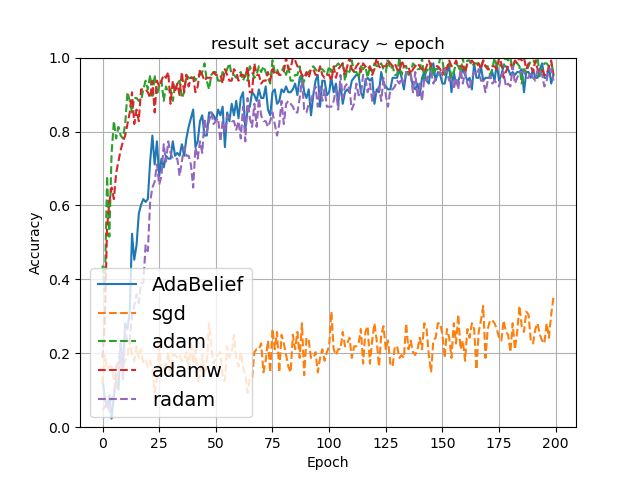

In [66]:
plot(curve_data=curve_data, ylim=(0,1))